1. Importing libraries

In [1]:
# importing libraries
import numpy as np
import tensorflow as tf
from mtcnn import MTCNN
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

In [2]:
# Model 1: 5 emotion, AffectNet + FER, Contempt
# Model 2: 5 emotion, FER only
# Model 3: 5 emotion, AffectNet + FER 
# Model 4: 5 emotion, AffectNet + FER, New technique
# Model 5: 5 emotion, AffectNet + FER, New technique, Complex model (BEST)
# Model 6: 5 emotion, AffectNet only

In [3]:
model = tf.keras.models.load_model('final_model.h5')
# model.load_weights('final_model.weights.h5')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,925,191 (22.60 MB)

 Trainable params: 5,920,517 (22.58 MB)

 Non-trainable params: 4,672 (18.25 KB)

 Optimizer params: 2 (12.00 B)

In [4]:
def preprocess_image(image):
    """
    Preprocesses an image using CLAHE, Morphological Illumination Correction, and Bilateral Filtering.
    
    Args:
        image (numpy array): Input image in BGR format.
        
    Returns:
        numpy array: Preprocessed image.
    """
    # Step 1: Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Step 2: Apply CLAHE for localized contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast_enhanced = clahe.apply(gray)
    # plt.imshow(contrast_enhanced)
    # plt.title("CLAHE")
    # plt.show()

    # Step 3: Apply Morphological Illumination Correction
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    background = cv2.morphologyEx(contrast_enhanced, cv2.MORPH_CLOSE, kernel)
    illumination_corrected = cv2.divide(contrast_enhanced, background, scale=255)
    
    # test0 = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
    # test1 = cv2.divide(test0, background, scale=255)
    # plt.imshow(background)
    # plt.title("Background")
    # plt.show()
    # plt.imshow(illumination_corrected)
    # plt.title("Illumination Corrected")
    # plt.show()
    
    # Step 4: Smooth with Bilateral Filter
    final_image = cv2.bilateralFilter(illumination_corrected, d=9, sigmaColor=75, sigmaSpace=75)

    # test3 =  cv2.bilateralFilter(gray, d=9, sigmaColor=75, sigmaSpace=75)
    # plt.imshow(final_image)
    # plt.title("Bilateral Filter")
    # plt.show()
    final_image = final_image / 255.0
    
    return final_image

In [5]:
EMOTIONS = [(1, "Anger"), (2, "Disgust"), (3, "Surprise"), (4, "Happy"), (5, "Neutral")]

def detect_faces_emo(image_path, detection_confidence=0.99, min_face_size=10):
    # Load the image using OpenCV
    image = cv2.imread(image_path)

    # Create an MTCNN detector instance
    detector = MTCNN()

    # Use the detector to detect faces in the image
    faces = detector.detect_faces(image)

    # Loop over the detected faces
    for face in faces:
        # Check the confidence score of the detection
        if face['confidence'] < detection_confidence:
            continue
        # Extract the bounding box coordinates
        x, y, width, height = face['box']
        # Check the size of the bounding box
        if min(width, height) < min_face_size:
            continue

        # Extract the face region from the image
        face_image = image[y:y+height, x:x+width]

        # Resize the face image to 96x96
        face_image_resized = cv2.resize(face_image, (96, 96))

        face_image_preprocessed = preprocess_image(face_image_resized)

        # Reshape the face image to match the input shape of the model
        face_image_reshaped = face_image_preprocessed.reshape((1, 96, 96, 1))
        plt.imshow(face_image_reshaped[0])
        plt.title("Sample")
        plt.show()

        # Use the model to predict the emotion of the face
        predicted_emo = model.predict(face_image_reshaped)[0]
        predicted_emo_sorted = sorted(list(enumerate(predicted_emo)), key=lambda x: x[1], reverse=True)

        # Extract the predicted probabilities for each emotion category

        probabilities = ["{}".format(round(prob * 100)) for index, prob in predicted_emo_sorted]
        print(probabilities)
        # Draw the predicted emotion label on the rectangle around the face
        label = EMOTIONS[np.argmax(predicted_emo)][1]

        cv2.putText(image, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1.8, (0, 255, 0), 3)

        # Draw a square rectangle around the face
        face_size = min(width, height)
        x_center = x + int(width / 2)
        y_center = y + int(height / 2)
        x1 = x_center - int(face_size / 2)
        y1 = y_center - int(face_size / 2)
        x2 = x_center + int(face_size / 2)
        y2 = y_center + int(face_size / 2)

        cv2.rectangle(image, (x1, y1), (x2, y2), (127, 255, 0), 2)

        # Draw a vertical table with the predicted emotion probabilities
        table_x, table_y = x1, y2 + 20
        for index, prob in predicted_emo_sorted:
            table_y += 40
            emotion = EMOTIONS[index][1]
            cv2.putText(image, emotion, (table_x, table_y), cv2.FONT_HERSHEY_SIMPLEX, 1.6, (255, 255, 255), 3)
            cv2.putText(image, "{}%".format(round(prob * 100)), (table_x + 250, table_y), cv2.FONT_HERSHEY_SIMPLEX, 1.4, (255, 255, 255), 3)

    # Save the image with the detected faces and predicted emotions to a file
    cv2.imwrite("detected_faces.jpg", image)

    # Return the path to the saved file
    return "detected_faces.jpg"

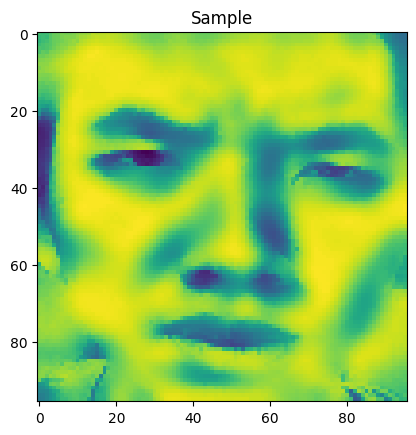

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
['64', '22', '14', '0', '0']


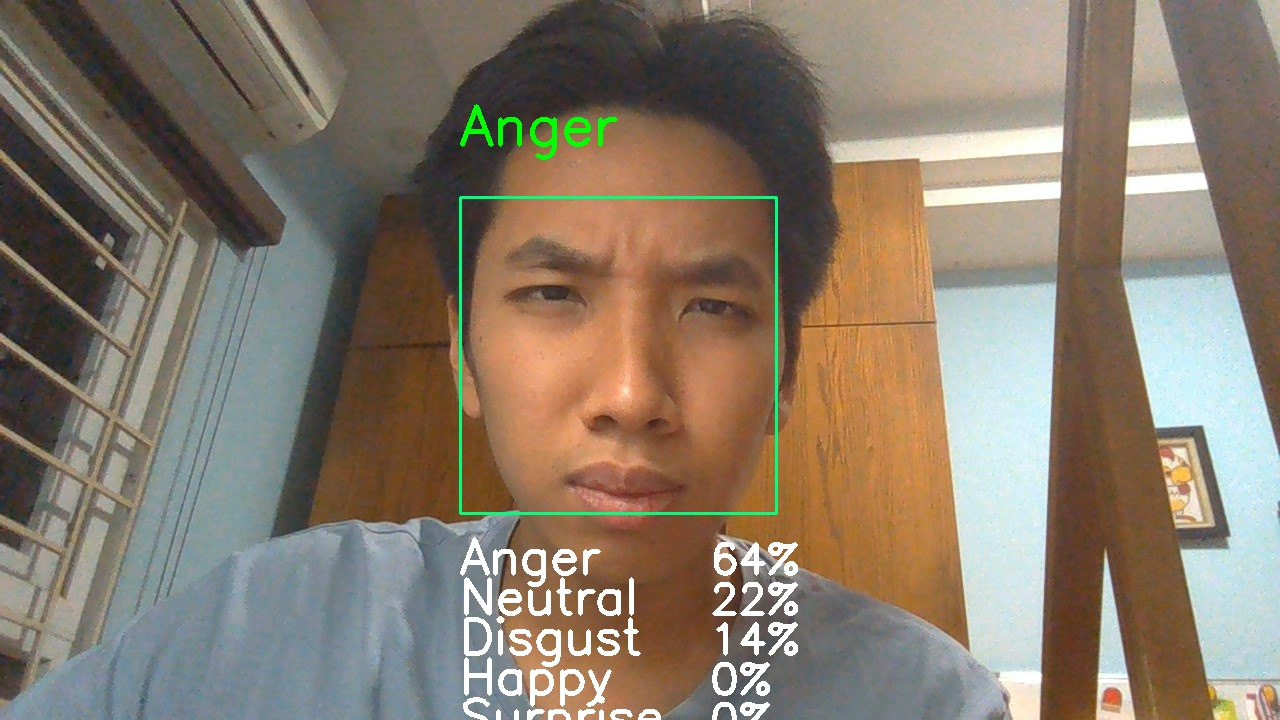

In [7]:
image_path = detect_faces_emo('TgMinh_Anger.jpg')

# Display the saved image
Image(filename=image_path)